# Import qbiome

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis
from qbiome.qutil import customDataFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
plt.style.use('ggplot')

# Data and initialization

In [2]:
! ls ../../infbiome_/data/HC/hc_Class_GTDB_denoised_filtered_percent.csv

../../infbiome_/data/HC/hc_Class_GTDB_denoised_filtered_percent.csv


In [3]:
dirname = 'example_data/'
data = '../../infbiome_/data/HC/hc_Class_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'
BIOMES=None
#BIOMES=['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'Fusobacteriota']

data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"},
                                      BIOMES=BIOMES)

data_=data.assign(source='gnd')
quantizer = Quantizer(num_levels=5)
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [4]:
BIOMES=list(data.variable.value_counts().index.values)

# Train qnet

In [ ]:
%%time
NUMQ=1
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator.train_qnet(
        features, label_matrix, alpha=0.2, min_samples_split=2, 
        out_fname=None)
    qnet_orchestrator.save_qnet('data1_class_ALPH_2_'+str(i)+'.joblib')
    #qnet_orchestrator.load_qnet('data1.joblib')

In [8]:
%%time
NUMQ=1
SW=26
forecasted_dict={}
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator_i = QnetOrchestrator(quantizer)
    qnet_orchestrator_i.load_qnet('data1_class_'+str(i)+'.joblib')
    forecaster_i = Forecaster(qnet_orchestrator_i)
    # can specify an end week or default to the max end week in the data
    forecasted_dict[i] = forecaster_i.forecast_data(
        label_matrix, 
        start_week=SW).assign(source='forecasted'+str(i))
    

100%|██████████| 1/1 [06:48<00:00, 408.38s/it]

CPU times: user 6min 44s, sys: 3.96 s, total: 6min 48s
Wall time: 6min 48s


In [9]:
#forecasted_dict[0]

DF=pd.concat([forecasted_dict[key] for key in np.arange(NUMQ)])

In [10]:
SUBJECTS=DF.subject_id.value_counts().index.values

In [11]:
property_map

,subject_id,hc,HCZ,sex,hc_Birth,HCZ_Birth,hc_Discharge,HCZ_Discharge,HCZ_discharge_birth_difference,HCZ_Category,...,NEC,IVH,ROP,BPD,Infection,total_Morbidities,Morbidity_Category,TIMPS score,TIMPS z-score,TIMPS Category
0,100001,30.0,-0.83,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
1,100001,27.5,-1.27,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
2,100001,27.0,-1.00,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
3,100001,25.0,-1.75,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
4,100002,27.5,-2.58,m,23.0,-1.22,30.0,-2.26,-1.04,Microcephaly,...,0,0,0,1,0,1,Mild,61.0,0.538462,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,100084,29.0,0.66,f,29.0,0.66,30.7,-0.04,-0.70,Optimal,...,0,0,0,0,0,0,None,63.0,0.933333,Normal
130,100084,29.0,0.02,f,29.0,0.66,30.7,-0.04,-0.70,Optimal,...,0,0,0,0,0,0,None,63.0,0.933333,Normal
131,100090,28.0,0.54,f,27.5,-0.45,31.0,-0.55,-0.10,Optimal,...,0,0,0,0,0,0,None,64.0,1.000000,Normal
132,100091,29.5,1.27,m,28.5,0.02,35.5,0.63,0.61,Optimal,...,0,0,0,0,0,0,None,NaN,NaN,NaN


In [12]:
property_map.Infection.value_counts()#[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates()

0    102
1     32
Name: Infection, dtype: int64

In [13]:
property_map.Morbidity_Category.value_counts()#[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates()

Severe    63
None      37
Mild      34
Name: Morbidity_Category, dtype: int64

In [17]:
from qbiome.qutil import qplot

In [64]:
Q=[]
for subject_id in tqdm(SUBJECTS):
    QF=None
    for i in np.arange(NUMQ):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().Infection.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


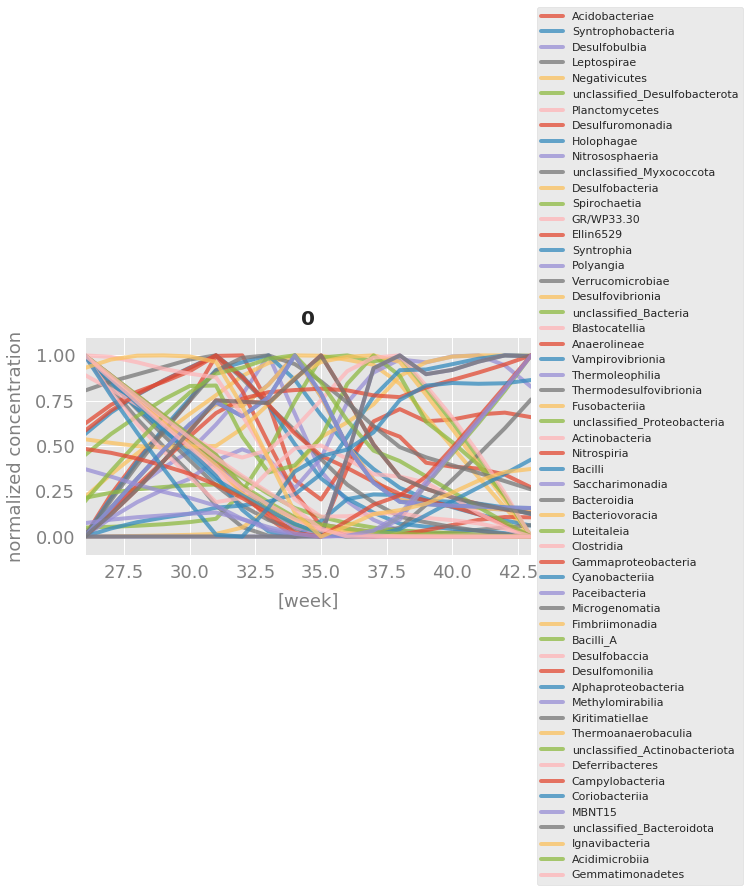

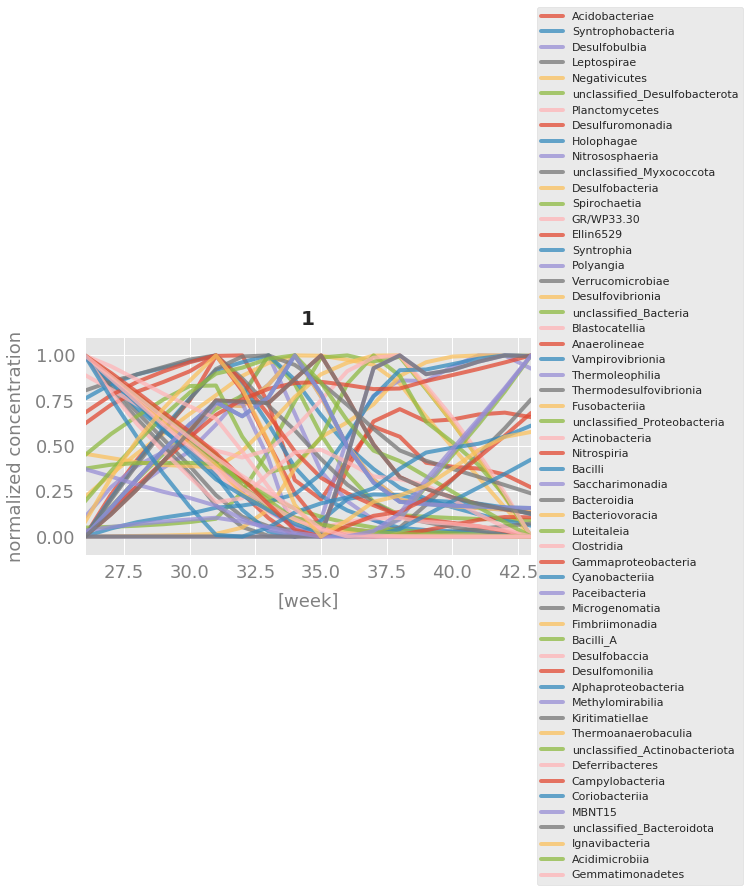

In [66]:
DD=pd.concat(Q)
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).median().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.7,save=False)

dd_os=dd[0]-dd[1]
#dd_om=dd['None']-dd['Severe']

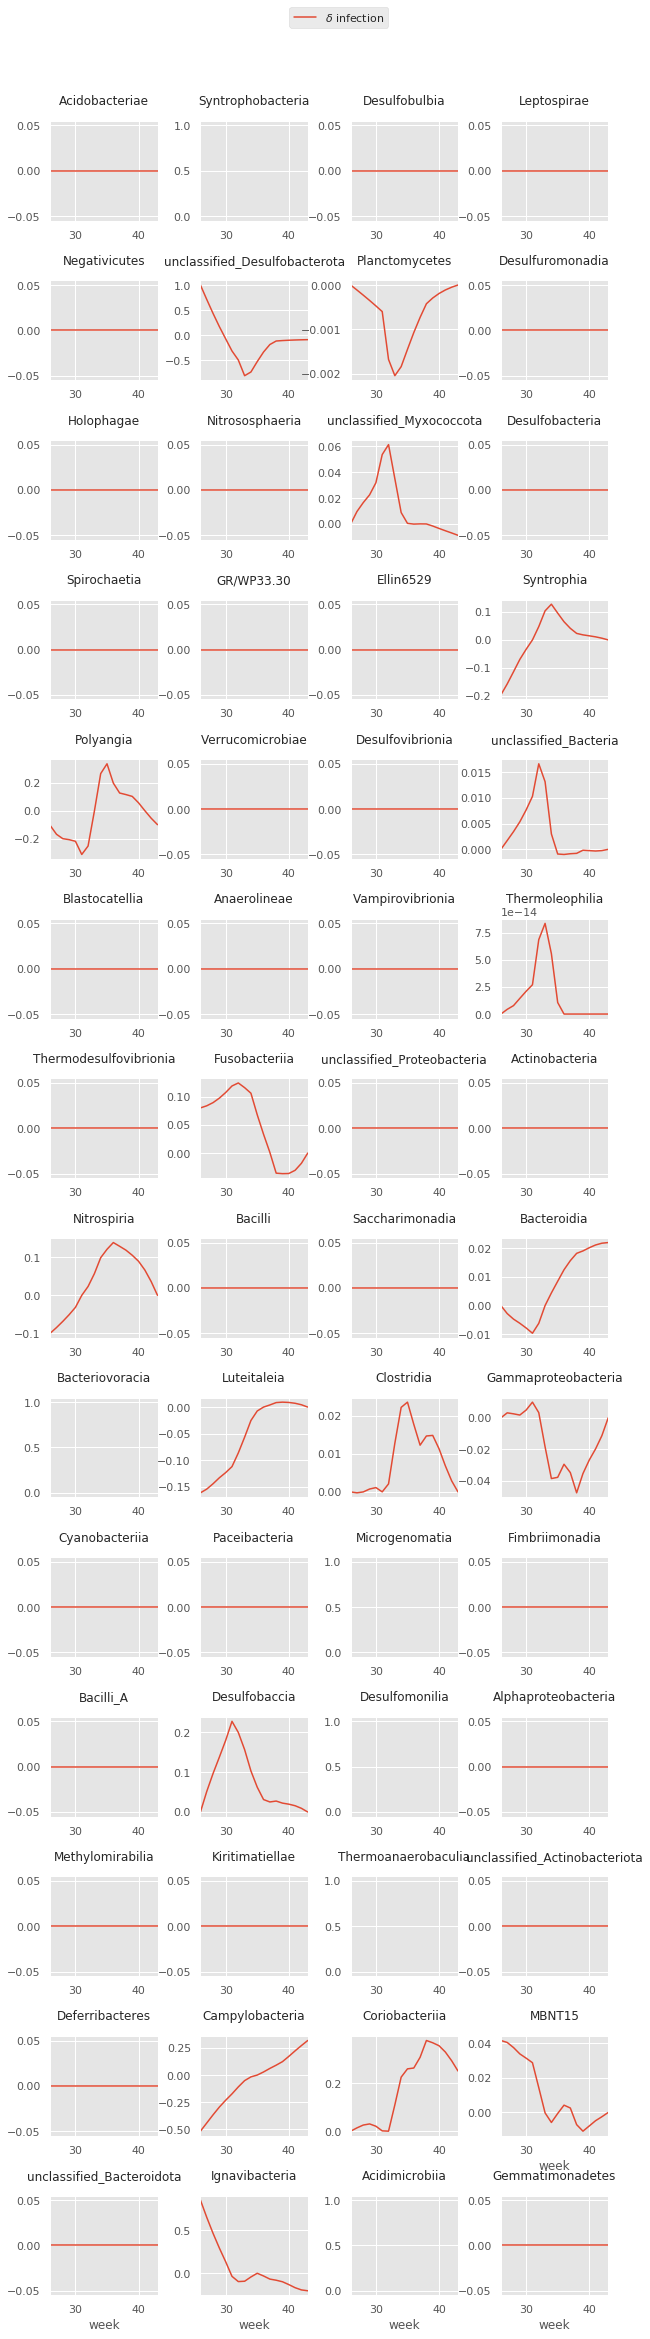

In [69]:
fig=plt.figure(figsize=[10,40])
plt.subplots_adjust(wspace=.4, hspace=.6)

count=0
C=4
R=len(BIOMES)//C
for i in BIOMES:
    count=count+1
    plt.subplot(R,C,count)
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ infection')
    #ax.legend()
    ax.set_title(i,fontsize=12,y=1.1)
    if count < len(BIOMES)-4:
        ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='best', bbox_to_anchor=(-1,23))
#qbiome.qutil.saveFIG('infection.png',axis=True)

In [62]:
Q=[]
for subject_id in tqdm(SUBJECTS):
    QF=None
    for i in np.arange(NUMQ):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().Morbidity_Category.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

100%|██████████| 39/39 [00:33<00:00,  1.15it/s]


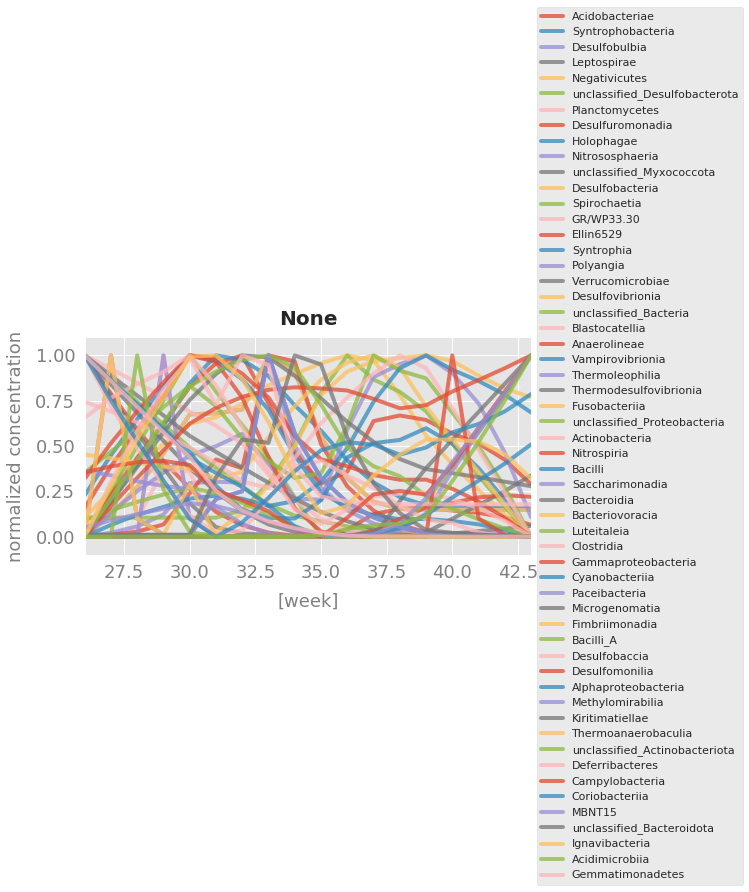

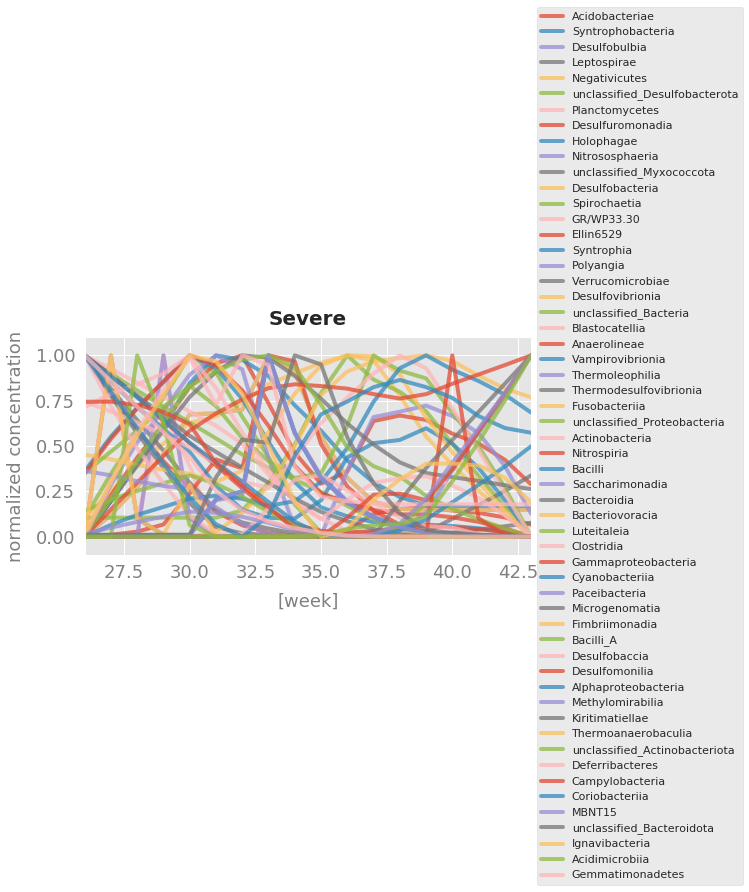

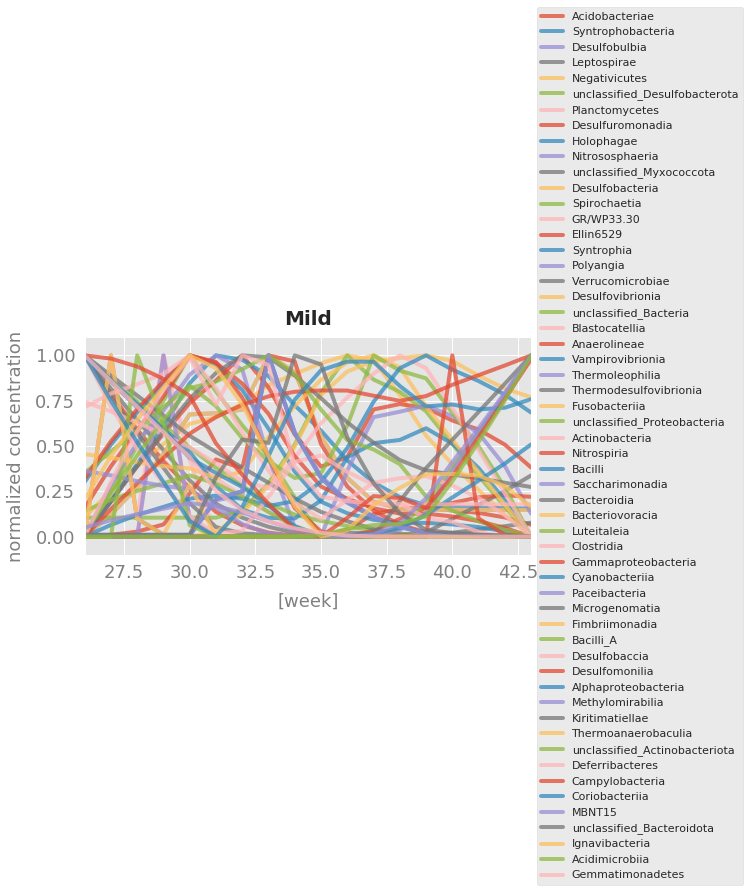

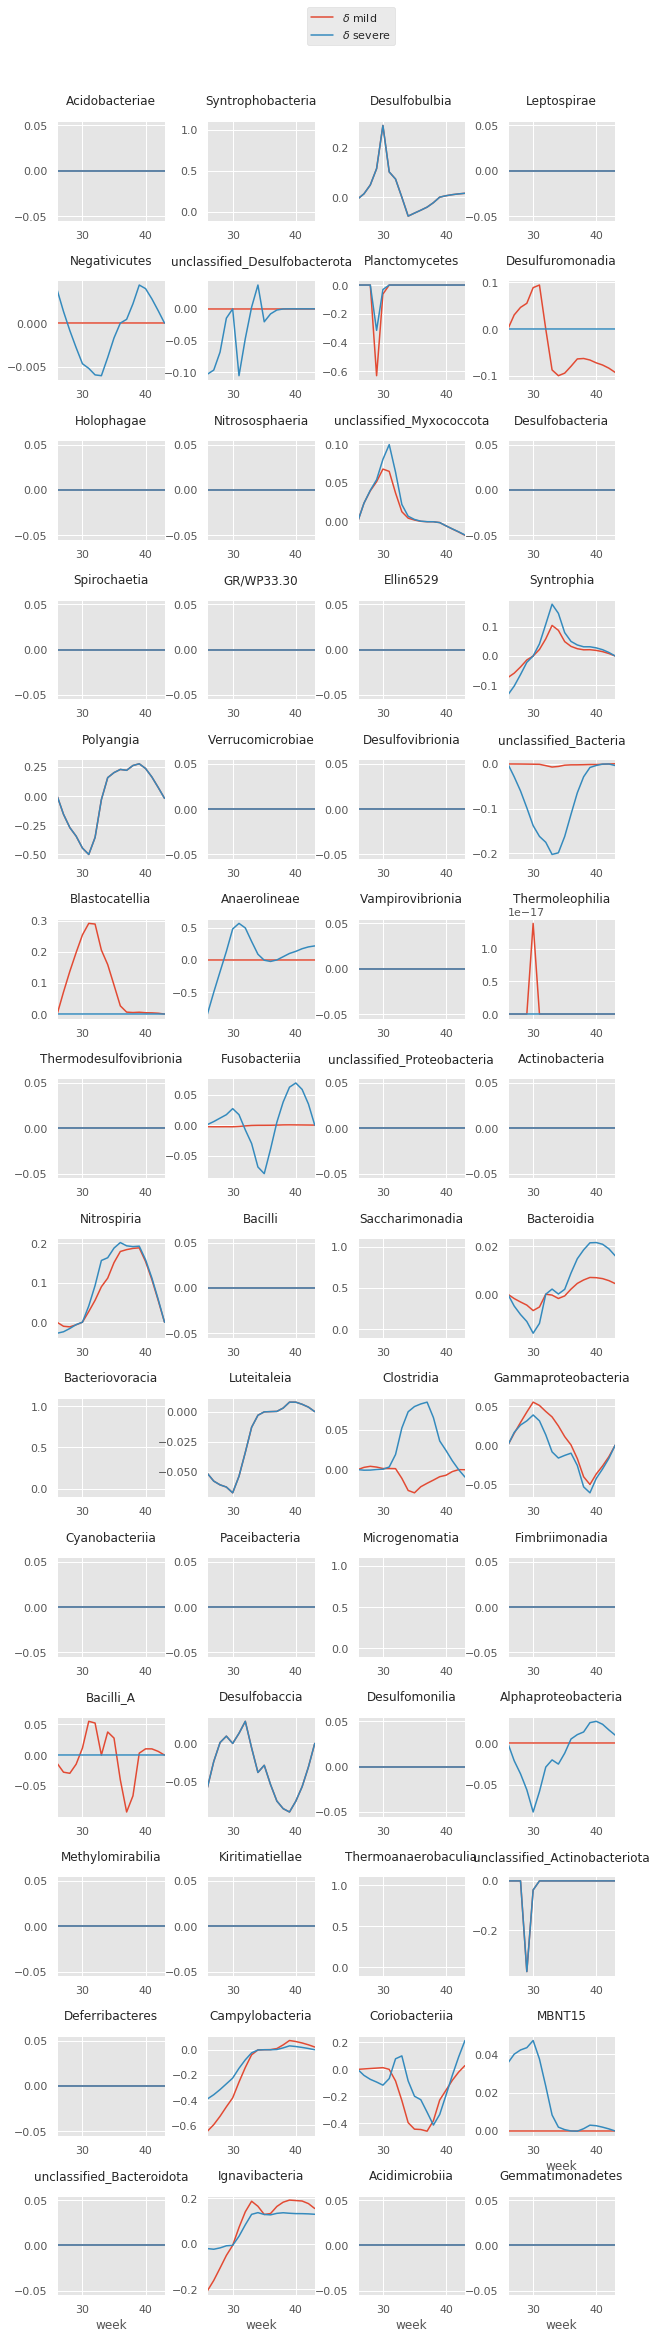

In [63]:
DD=pd.concat(Q)
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).median().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.6,save=False)

dd_os=dd['None']-dd['Mild']
dd_om=dd['None']-dd['Severe']

fig=plt.figure(figsize=[10,40])
plt.subplots_adjust(wspace=.4, hspace=.6)

count=0
C=4
R=len(BIOMES)//C
for i in BIOMES:
    count=count+1
    plt.subplot(R,C,count)
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ mild')
    ax=dd_om[i].plot(ax=ax,label='$\delta$ severe')
    #ax.legend()
    ax.set_title(i,fontsize=12,y=1.1)
    if count < len(BIOMES)-4:
        ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='best', bbox_to_anchor=(-1,23))


In [28]:
Q=[]
for subject_id in tqdm(SUBJECTS):
    QF=None
    for i in np.arange(NUMQ):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().HCZ_Category.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

from qbiome.qutil import qplot
DD=pd.concat(Q)

100%|██████████| 39/39 [00:33<00:00,  1.18it/s]


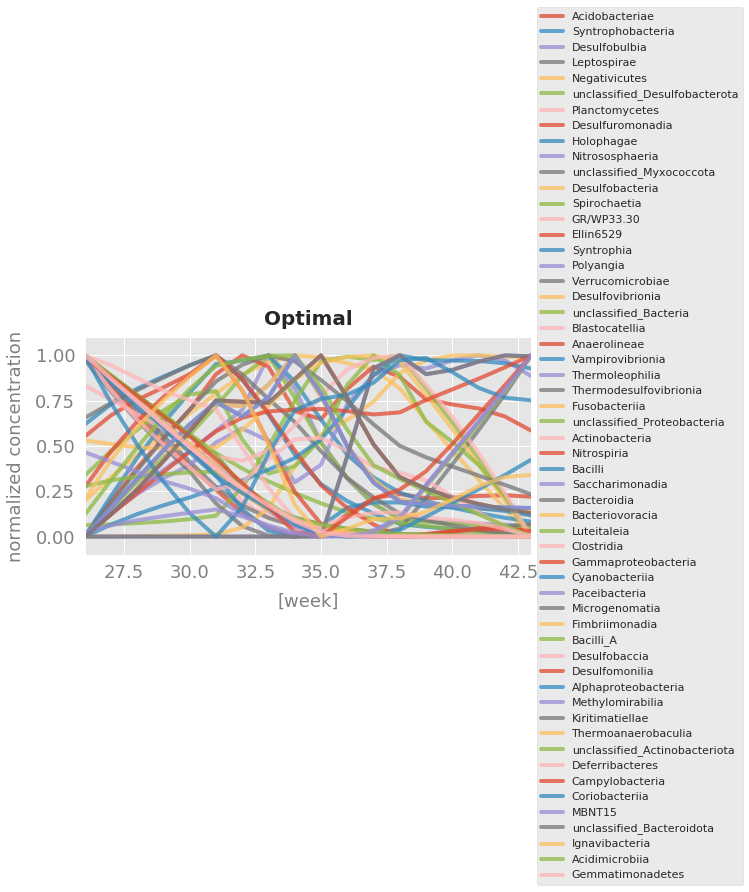

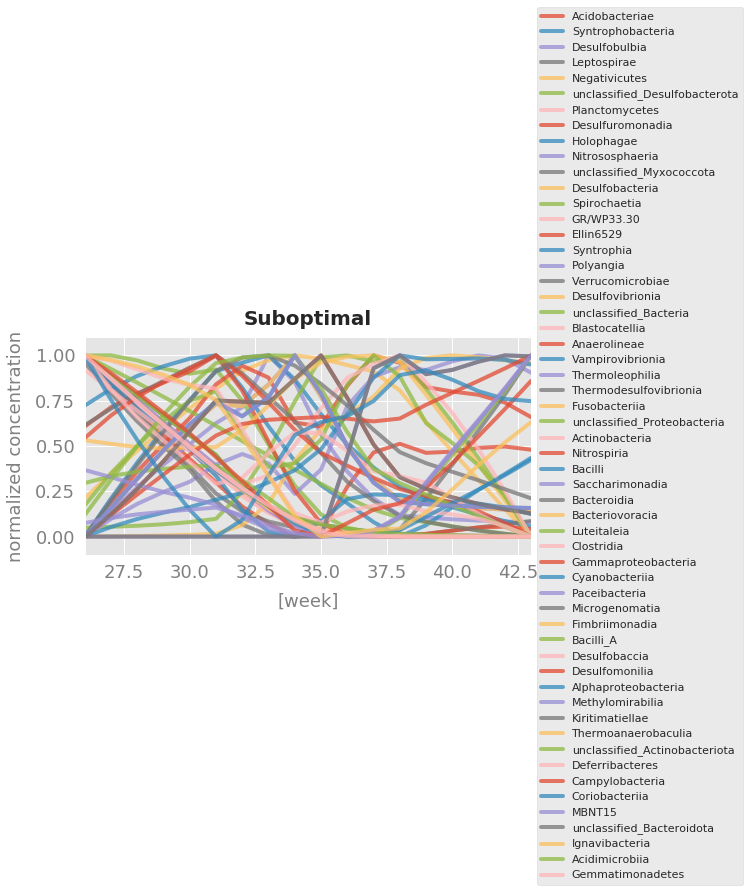

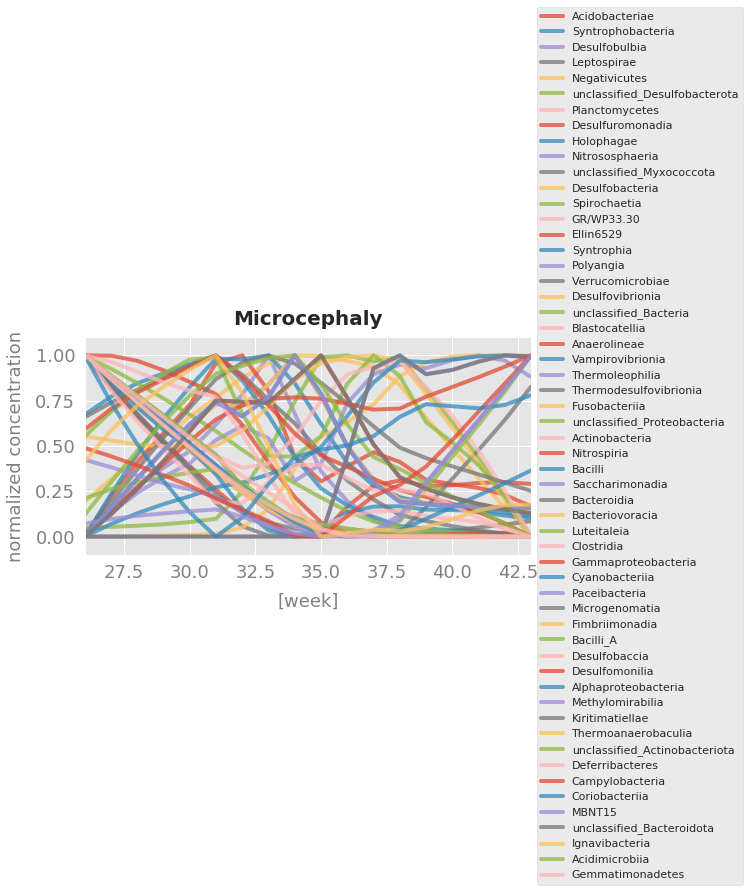

In [60]:
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).mean().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=True,normalize=True,title=phn,lowess_fraction=0.7,save=False)

dd_os=dd['Optimal']-dd['Suboptimal']
dd_om=dd['Optimal']-dd['Microcephaly']

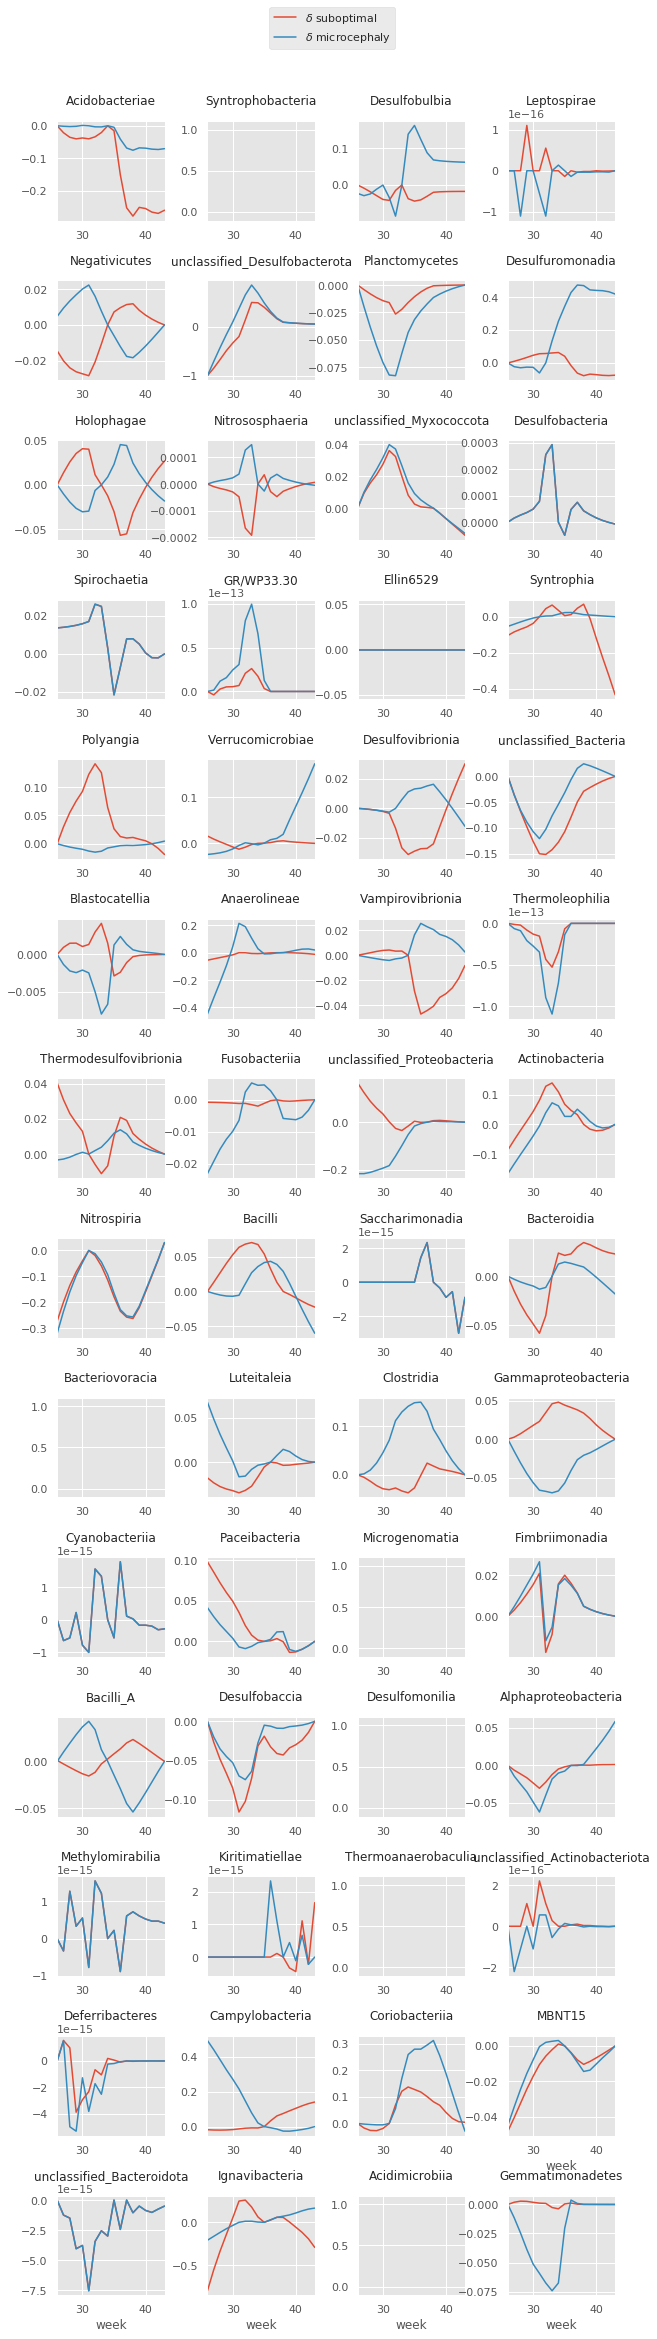

In [61]:
fig=plt.figure(figsize=[10,40])
plt.subplots_adjust(wspace=.4, hspace=.6)

count=0
C=4
R=len(BIOMES)//C
for i in BIOMES:
    count=count+1
    plt.subplot(R,C,count)
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ suboptimal')
    ax=dd_om[i].plot(ax=ax,label='$\delta$ microcephaly')
    #ax.legend()
    ax.set_title(i,fontsize=12,y=1.1)
    if count < len(BIOMES)-4:
        ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='best', bbox_to_anchor=(-1,23))


# Use the forecaster to predict new data

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [ ]:
new_subject_id = '101'
np.random.seed(10001)
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = new_subject_id
new_patient

In [ ]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

In [ ]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=29, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [ ]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', [new_subject_id])
new_patient_df

In [ ]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)
new_patient_df

In [ ]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)
new_patient_matrix.shape

## Forecast the data starting from week 7 to the last week

In [ ]:
# takes 2 minutes to run
new_patient_forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=29
)

In [ ]:
new_patient_forecasted.head()

The NaNs are due to the random values we generated falling outside the quantization range.

In [ ]:
plottable = new_patient_forecasted[new_patient_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

In [ ]:
# zoom into the first 20 weeks
plottable = new_patient_forecasted[
    (new_patient_forecasted.variable.isin(BIOMES)) &
    (new_patient_forecasted.week <= 50)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()